In [1]:
# Cell 0: Install dependencies (run once)
!pip install --quiet \
    numpy==1.23.5 \
    opencv-python \
    pillow \
    pytesseract \
    pyocr \
    tensorflow \
    scikit-learn \
    matplotlib \
    albumentations \
    requests \
    requests-cache \
    tenacity \
    easyocr


In [48]:
# Cell 1: Setup & Imports

# For notebook display and reproducibility
%matplotlib inline
import random
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Your package modules
from model import SETINFO
from model.prediction import card_prediction_processing, card_ocr_crop, get_card_info
from model.modelling import build_cnn, symbols_model
from model.text_detection import get_pokeid, _preprocess_corner
from model.augmentation import augmenter

# Fix random seeds (optional)
random.seed(24)
np.random.seed(24)

print("Setup complete. SETINFO keys:", SETINFO[:,0])


Setup complete. SETINFO keys: ['dv1' 'swsh9' 'swsh45' 'swsh6' 'swsh12pt5' 'xy1' 'xy2' 'xy3' 'g1' 'xy4'
 'xy6' 'xy7' 'dp1' 'dp2' 'sm4' 'swsh10' 'sv4' 'sv3pt5' 'sv3' 'sv2']


URL: https://images.pokemontcg.io/swsh45/20_hires.png
Set: swsh45 | Index: 20


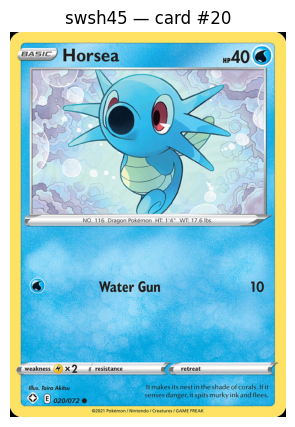

In [64]:
# Cell 2: Fetch & Display a Random Card Image

# 1. Pick a random set and a random card index
sets = SETINFO[:, 0]
set_id = random.choice(sets)
total = int(SETINFO[SETINFO[:, 0] == set_id, 1][0])
card_index = random.randint(1, total)

# 2. Build URL and download
url = f"https://images.pokemontcg.io/{set_id}/{card_index}_hires.png"
response = requests.get(url, stream=True)
card_img = Image.open(response.raw).convert("RGB")

# 3. Display
plt.figure(figsize=(4,5))
plt.imshow(card_img)
plt.axis('off')
plt.title(f"{set_id} — card #{card_index}")

# 4. Print out which card we grabbed
print("URL:", url)
print("Set:", set_id, "| Index:", card_index)

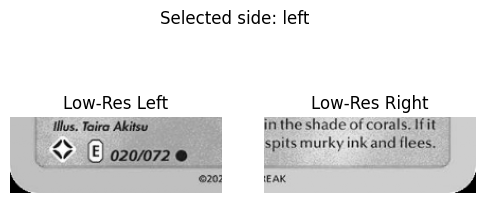

In [65]:
# Cell 3: Low-Res Corner Crops

import numpy as np
import matplotlib.pyplot as plt
from model import SETINFO
from model.prediction import card_prediction_processing

# Convert PIL → NumPy array
card_np = np.array(card_img)

# Produce the two 72×200 grayscale crops (float32 in [0,1])
low_left, low_right = card_prediction_processing(card_np)

# Determine which side contains the set info
side = SETINFO[SETINFO[:,0] == set_id, 3][0]  # 'left' or 'right'

# Squeeze off the singleton dims for plotting
patch_left  = low_left .squeeze()
patch_right = low_right.squeeze()

# Plot both
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(patch_left,  cmap='gray')
axes[0].set_title("Low-Res Left")
axes[0].axis('off')
axes[1].imshow(patch_right, cmap='gray')
axes[1].set_title("Low-Res Right")
axes[1].axis('off')
plt.suptitle(f"Selected side: {side}")
plt.show()


(-0.5, 199.5, 71.5, -0.5)

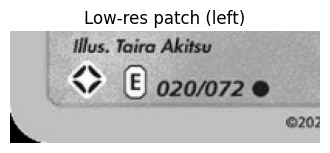

In [66]:
# Cell 3.1: Display only the low-res corner patch
from model.prediction import card_prediction_processing

# get both corners
low_left, low_right = card_prediction_processing(card_np)
side = SETINFO[SETINFO[:,0] == set_id, 3][0]
patch = (low_left if side == "left" else low_right).squeeze()

plt.figure(figsize=(4,3))
plt.imshow(patch, cmap="gray")
plt.title(f"Low-res patch ({side})")
plt.axis("off")


(-0.5, 599.5, 215.5, -0.5)

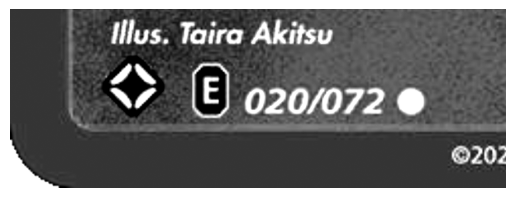

In [67]:
pil_crop = _preprocess_corner(card_np, set_id)
plt.imshow(pil_crop, cmap='gray'); plt.axis('off')


In [68]:
# Cell 3.2: Raw OCR on the 72×200 patch
import easyocr
reader = easyocr.Reader(["en"], gpu=False, verbose=False)

img3 = cv2.cvtColor((patch*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
results = reader.readtext(img3, allowlist="0123456789/", batch_size=1)
print("EasyOCR raw:", results)


EasyOCR raw: [([[39, 3], [133, 3], [133, 17], [39, 17]], '105146', 0.2342519612313558), ([[75, 25], [155, 25], [155, 45], [75, 45]], '6020/072', 0.7120480577785835)]


In [69]:
from model.text_detection import get_pokeid
poke_id = get_pokeid(card_np, set_id)
poke_id

'20'

In [62]:
# Cell 6: Fetch card info from the PokéTCG API

from model.prediction import get_card_info

# 1) We already have `set_id` (either your ground-truth or model’s prediction)
# 2) And you just extracted `poke_id` via get_pokeid()
print(f"Looking up info for set={set_id!r}, card={poke_id!r}…")

info = get_card_info(set_id, poke_id)
if info is None:
    print("⚠️  API lookup failed.")
else:
    rarity, market_price, image_url = info
    print(f"Rarity:       {rarity}")
    print(f"Avg. Price:   ${market_price:.2f}")
    print(f"Card image:   {image_url}")


2025-05-28 15:21:53,737 [INFO] model.prediction: Fetching card info from https://api.pokemontcg.io/v2/cards/xy2-22


Looking up info for set='xy2', card='22'…
Rarity:       Common
Avg. Price:   $0.05
Card image:   https://images.pokemontcg.io/xy2/22_hires.png
